# Sequence disambugation
This is my first attempt at sequence disambiguation. I did not manage to get all the phenomena right but I will leave some pointers for the next time.

As usual we start by importing all libraries

In [1]:
from __future__ import print_function
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib
import seaborn as sns

from network import BCPNNFast, NetworkManager
from data_transformer import build_ortogonal_patterns
from plotting_functions import plot_state_variables_vs_time, plot_network_activity, plot_network_activity_angle
from plotting_functions import  plot_adaptation_dynamics, plot_weight_matrix, plot_winning_pattern

%matplotlib inline
matplotlib.rcParams.update({'font.size': 22})

np.set_printoptions(suppress=True, precision=2)

sns.set(font_scale=2.0)

#### Git machinery

In [2]:
run_old_version = False
if run_old_version:
    hash_when_file_was_written = 'b726a9686e1732fad018e61c7283fa5bf2e7ab06'
    hash_at_the_moment = subprocess.check_output(["git", 'rev-parse', 'HEAD']).strip()
    print('Actual hash', hash_at_the_moment)
    print('Hash of the commit used to run the simulation', hash_when_file_was_written)
    subprocess.call(['git', 'checkout', hash_when_file_was_written])

##### Parameters

In [3]:
# Patterns parameters
hypercolumns = 4
minicolumns = 10
n_patterns = 10  # Number of patterns

# Network parameters
tau_z_pre = 1.000
tau_z_post = 0.125
tau_z_pre_ampa = 0.005
tau_z_post_ampa = 0.005
tau_a = 2.7

# Manager properties
dt = 0.001
T_training = 0.5
T_ground = 3.0
T_recalling = 5.0
values_to_save = ['o', 'a', 'z_pre', 'z_post', 'p_pre', 'p_post', 'p_co', 'z_co', 'w',
                  'z_pre_ampa', 'z_post_ampa', 'p_pre_ampa', 'p_post_ampa', 'p_co_ampa', 'z_co_ampa', 'w_ampa']

traces_to_plot = [2, 3, 4]


#### Patterns and network building

In [4]:
# Build patterns
patterns_dic = build_ortogonal_patterns(hypercolumns, minicolumns)
patterns = list(patterns_dic.values())
sequence1 = [patterns[0], patterns[1], patterns[4], patterns[5], patterns[2], patterns[3]]
sequence2 = [patterns[6], patterns[7], patterns[4], patterns[5], patterns[8], patterns[9]]

"""
Sequence1: 01-45-23
Sequence2: 67-45-89
"""

# Build the network
nn = BCPNNFast(hypercolumns, minicolumns, tau_z_post=tau_z_post, tau_z_pre=tau_z_pre,
               tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, T_training=T_training, T_ground=T_ground, T_recalling=T_recalling,
                         values_to_save=values_to_save)

#### Training

In [5]:
repetitions = 3

for i in range(repetitions):
    print('repetitions', i)
    # First sequence
    for pattern in sequence1:
        nn.k = 1.0
        manager.run_network(time=manager.time_training, I=pattern)
    # Space between the sequences

    nn.k = 1.0
    manager.run_network(time=manager.time_ground)

    # Second sequence
    for pattern in sequence2:
        nn.k = 1.0
        manager.run_network(time=manager.time_training, I=pattern)

    # Second pause
    nn.k = 1.0
    manager.run_network(time=manager.time_ground)

repetitions 0
repetitions 1
repetitions 2


In [6]:
manager.T_total = (len(sequence1) * (T_training) + len(sequence2) * (T_training) + 2 * T_ground) * repetitions
manager.n_patterns = n_patterns
manager.patterns = patterns

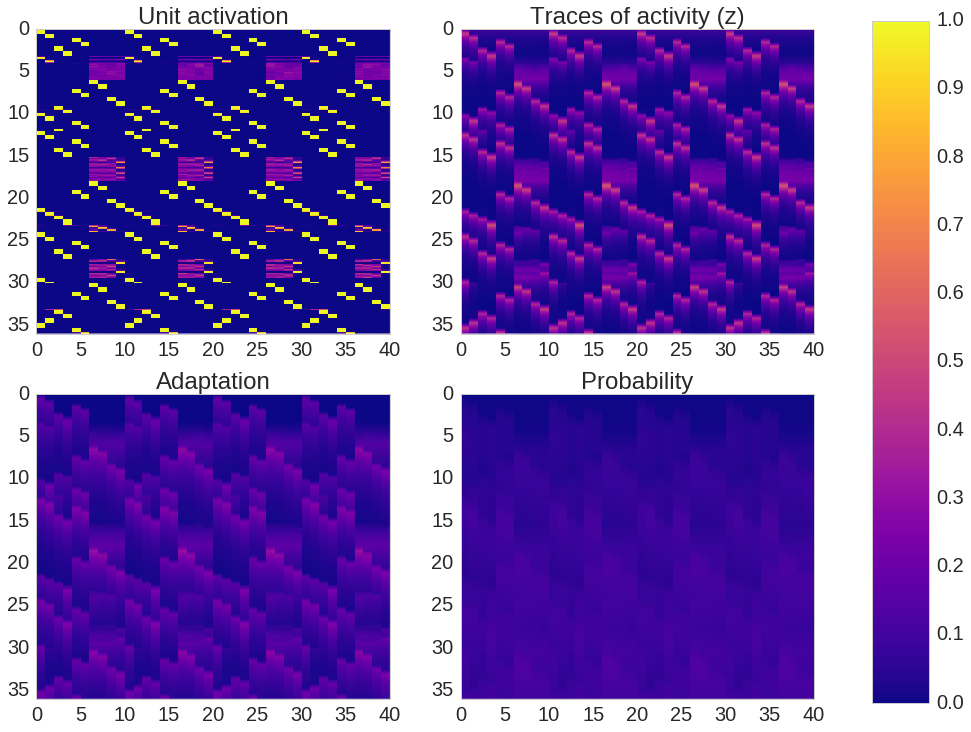

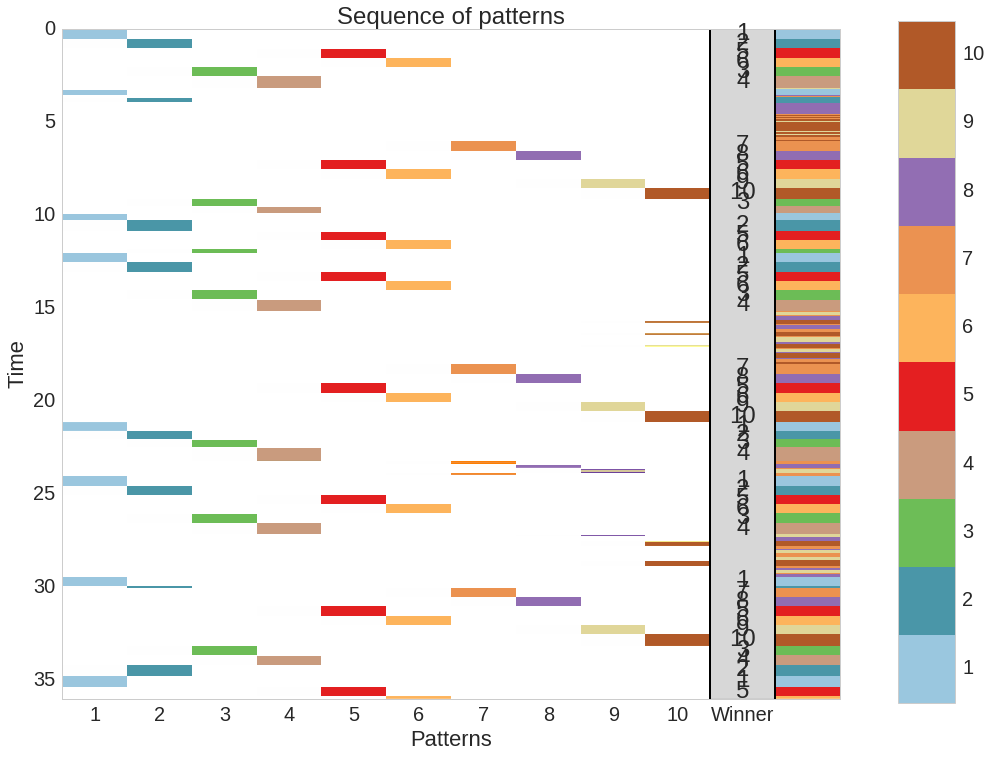

In [7]:
plot_network_activity(manager)
plot_winning_pattern(manager, separators=False, remove=T_training - 0.1)

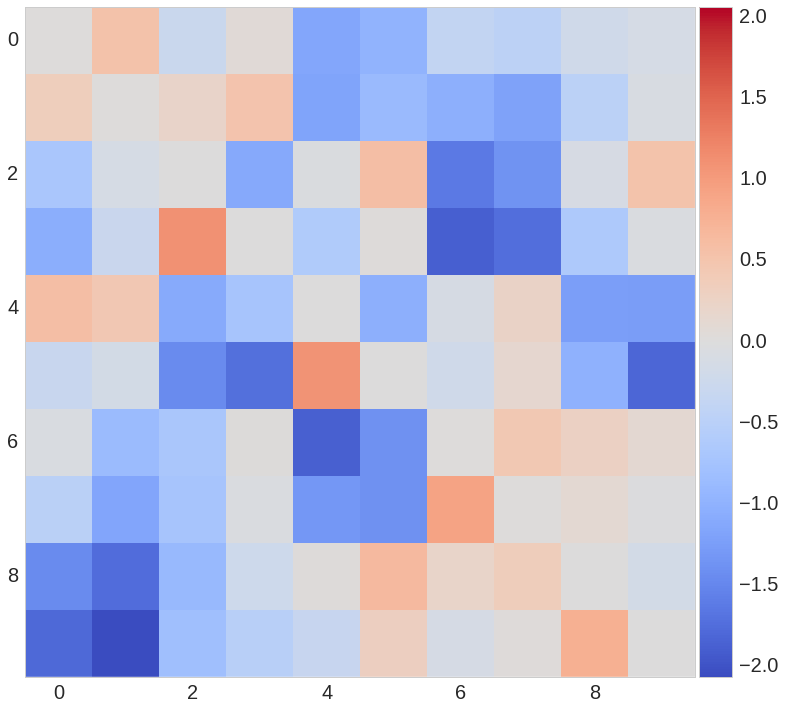

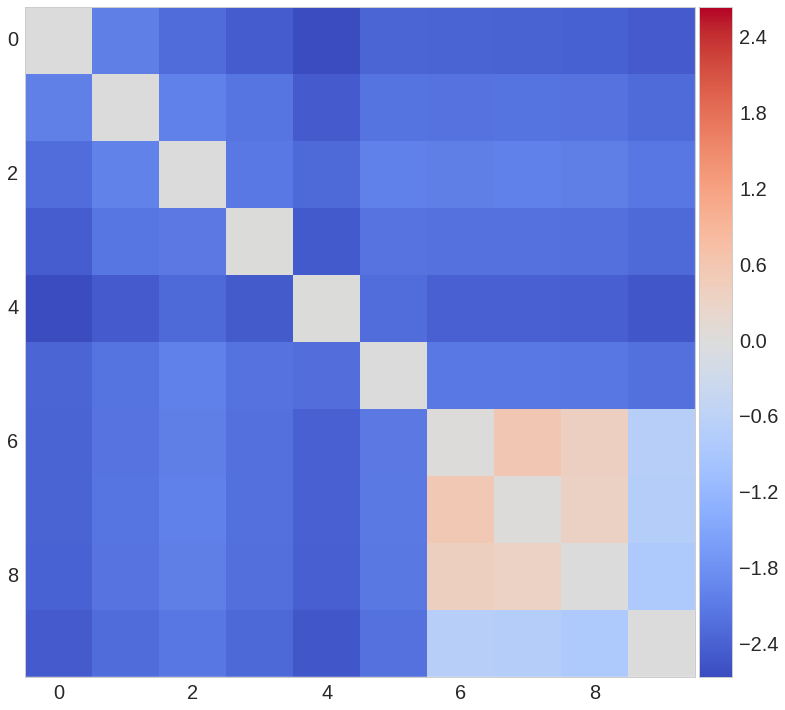

In [8]:
plot_weight_matrix(nn, ampa=False, one_hypercolum=True)
plot_weight_matrix(nn, ampa=True, one_hypercolum=True)

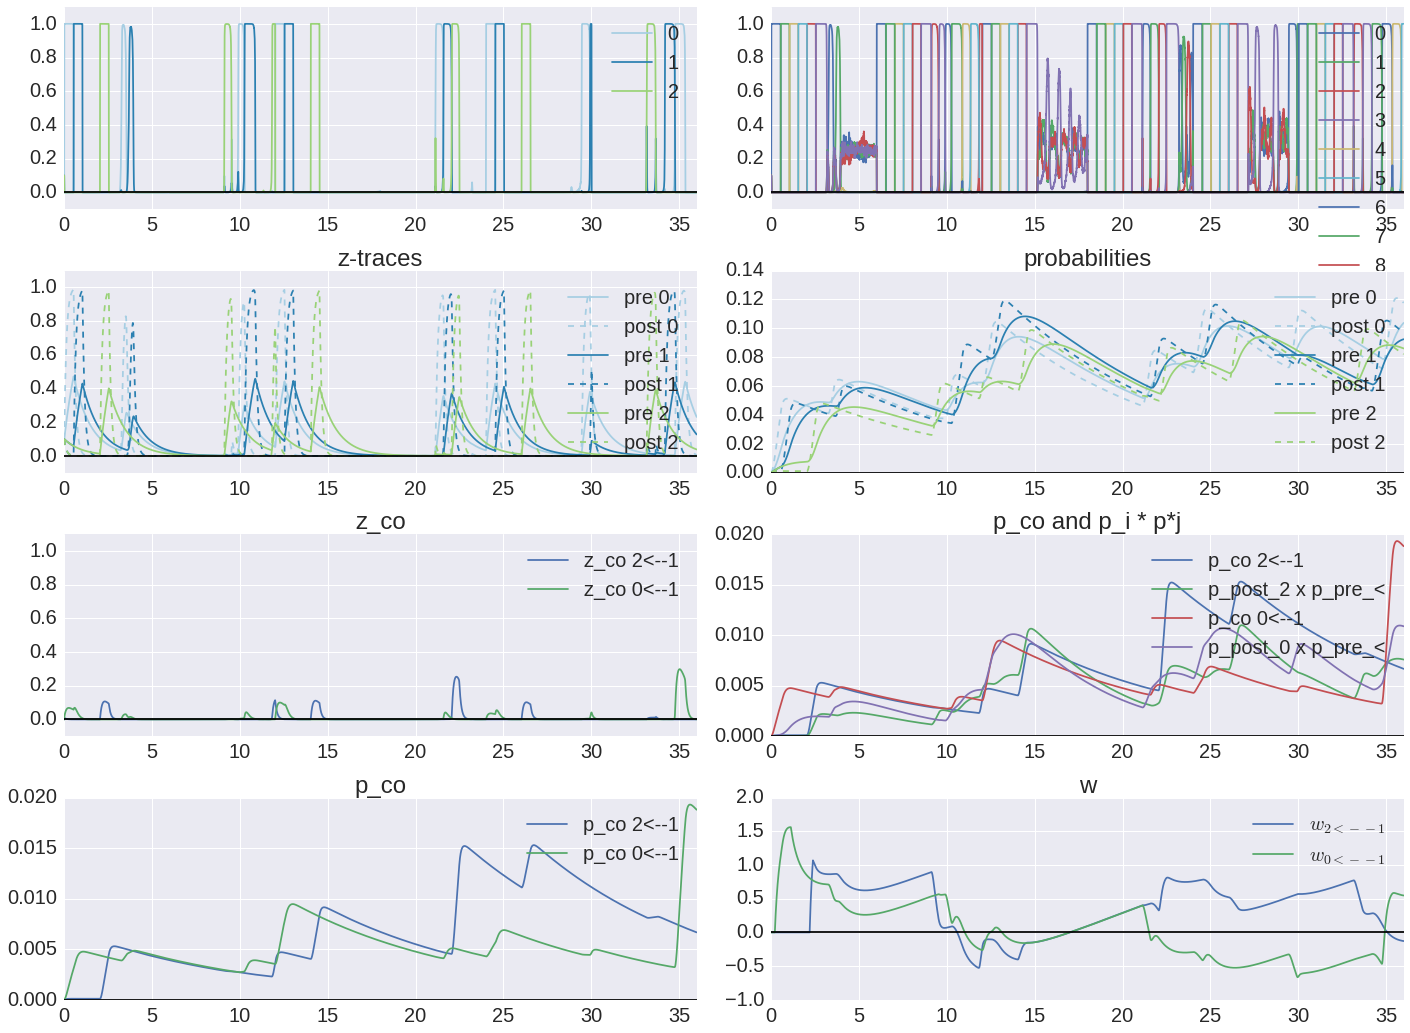

In [9]:
traces_to_plot = [0, 1, 2]
plot_state_variables_vs_time(manager, traces_to_plot, ampa=False)

#### Recalling  (cue at 0)

In [10]:
nn.g_w = 1.0
nn.g_w_ampa = 1.0
nn.k = 0.0

T_cue = 0.25
time_cue = np.arange(0, T_cue, dt)
pattern_cue = 0

nn.reset_values(keep_connectivity=True)
manager.empty_history()
manager.run_network(time=time_cue, I=patterns[pattern_cue])
manager.run_network_recall(reset=False, empty_history=False)

manager.T_total = 1 * (T_recalling + T_cue)

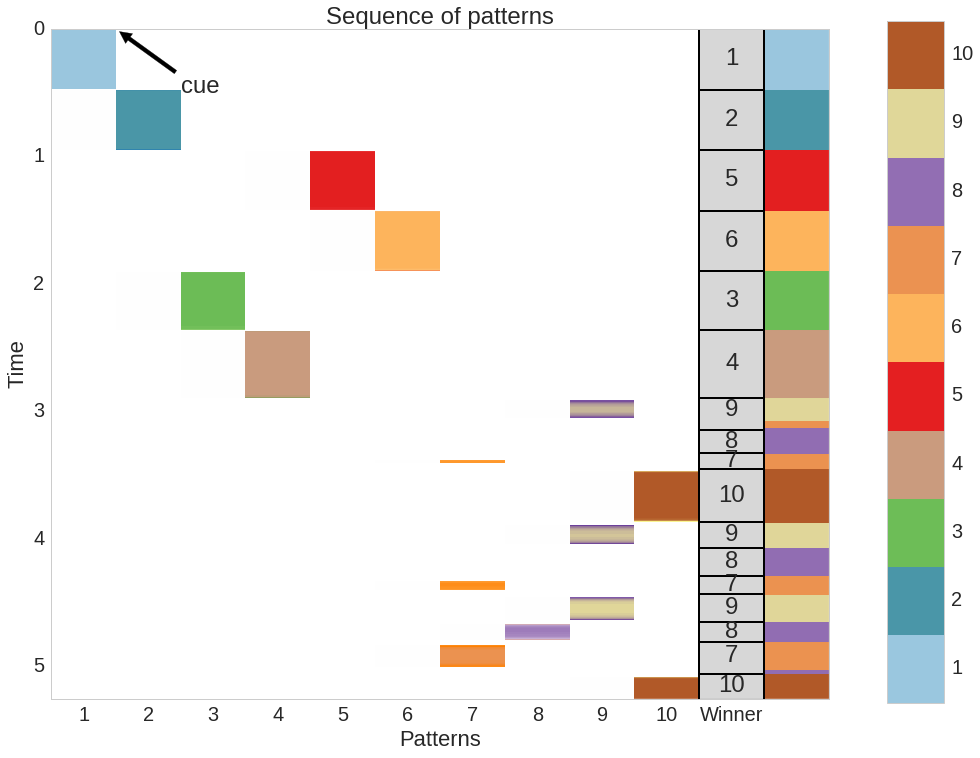

In [11]:
sns.set_style("whitegrid", {'axes.grid': False})
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.annotate('cue', xy=(pattern_cue + 1, 0), xytext=(pattern_cue + 2, 0.5),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plot_winning_pattern(manager, separators=True, remove=0.1, ax=ax)


#### Recalling  (cue at 6)

In [12]:
T_cue = 0.25
time_cue = np.arange(0, T_cue, dt)
pattern_cue = 6

nn.reset_values(keep_connectivity=True)
manager.empty_history()
manager.run_network(time=time_cue, I=patterns[pattern_cue])
manager.run_network_recall(reset=False, empty_history=False)

manager.T_total = 1 * (T_recalling + T_cue)

In [13]:
nn.get_parameters()

{'g_I': 10.0,
 'g_a': 97.0,
 'g_beta': 1,
 'g_w': 1.0,
 'g_w_ampa': 1.0,
 'k': 0,
 'sigma': 1.0,
 'tau_a': 2.7,
 'tau_m': 0.05,
 'tau_p': 10.0,
 'tau_z_post': 0.125,
 'tau_z_post_ampa': 0.005,
 'tau_z_pre': 1.0,
 'tau_z_pre_ampa': 0.005}

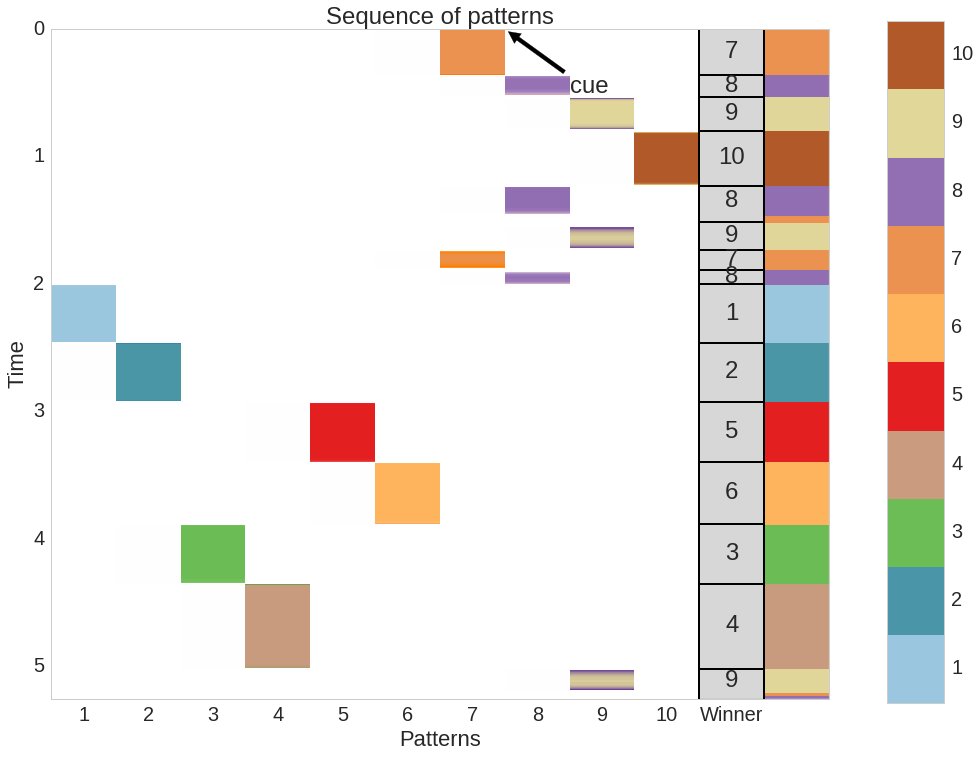

In [14]:
sns.set_style("whitegrid", {'axes.grid': False})
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.annotate('cue', xy=(pattern_cue + 1, 0), xytext=(pattern_cue + 2, 0.5),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plot_winning_pattern(manager, separators=True, remove=0.1, ax=ax)


In [15]:
from analysis_functions import calculate_winning_pattern_from_distances
from analysis_functions import calculate_patterns_timings, calculate_angle_from_history

In [16]:
angles = calculate_angle_from_history(manager)
winning = calculate_winning_pattern_from_distances(angles)
timming_patterns = calculate_patterns_timings(winning, dt)

pprint.pprint(timming_patterns)

[(0, 0.001, 0.0, 0.0),
 (6, 0.36099999999999999, 0.0, 0.35999999999999999),
 (7, 0.16900000000000001, 0.35999999999999999, 0.52800000000000002),
 (8, 0.26800000000000002, 0.52800000000000002, 0.79500000000000004),
 (9, 0.434, 0.79500000000000004, 1.228),
 (7, 0.23999999999999999, 1.228, 1.4670000000000001),
 (6, 0.049000000000000002, 1.4670000000000001, 1.5150000000000001),
 (8, 0.214, 1.5150000000000001, 1.728),
 (6, 0.161, 1.728, 1.8880000000000001),
 (7, 0.114, 1.8880000000000001, 2.0009999999999999),
 (0, 0.45800000000000002, 2.0009999999999999, 2.4580000000000002),
 (1, 0.46500000000000002, 2.4580000000000002, 2.9220000000000002),
 (4, 0.47500000000000003, 2.9220000000000002, 3.3959999999999999),
 (5, 0.48799999999999999, 3.3959999999999999, 3.883),
 (2, 0.46700000000000003, 3.883, 4.3490000000000002),
 (3, 0.66700000000000004, 4.3490000000000002, 5.0149999999999997),
 (8, 0.188, 5.0149999999999997, 5.202),
 (6, 0.014999999999999999, 5.202, 5.2160000000000002),
 (7, 0.008000000000

#### Git reset

In [17]:
if run_old_version:
    subprocess.call(['git', 'checkout', 'master'])